# 4. Error detection

In [10]:
# Author: Carl Enslin

In [13]:
# Importing the toolbox (takes several seconds)
import pandas as pd
from pathlib import Path
import numpy as np
import os
import matplotlib.pyplot as plt
from collections import namedtuple
from scipy.spatial import distance
from DeepWorkOut import Analyzer

In [15]:
DLCscorer='DLC_resnet101_DeepWorkOutJan31shuffle3_100000'
folderPath = 'C:\\Users\\ujtjf\\Desktop\\LAMA_Projekt\\Error_detection_h5\\Pla_kor_4DLC_resnet101_DeepWorkOutJan31shuffle3_100000.h5'

# Create an object
video_1 = Analyzer(folderPath, DLCscorer, 30)

# Cleaning and calibrating the data for further processing
video_1.clean_data(pcutoff = 0.8, min_rate = 0.5)
video_1.calibrate_metric('ankleleft', 'kneeleft', 42.0)

C:\Users\ujtjf\Anaconda3\lib\site-packages\pandas\core\generic.py:3887: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


In [16]:
def error_correction(time_to_analyse, video_object):

        # examples:
        # time_to_analyse = 1, 2, 3, 4
        # video_object = object1, object2

    # Analyse the exercise every k seconds, k e [1, 4]
    # Types of error: - Head position: _hp
    #                 - Butt in the air: _ba
    #                 - Hollow creed: _hc
    #                 - Shoulder-elbow position: _sp
    #                 - Knee position: _kp

    # Calculating the numbers of frames to be analysed from the video
    frames_to_analyse = video_object.fps * time_to_analyse

   

    # If the number of frames the user proposed is greater than the maxium video length
    if frames_to_analyse > len(video_object.df):
        frames_to_analyse = len(video_object.df) 
        print('Attention! The number of frames you want exceeds the maximum video length. The number of frames has therefore been set to the maximum possible.')


    # Head position

    # Position error exits (True) or not (False)
    error_hp = False

    # Initialize correction variable
    vertical_correction_hp = 0

    yvalue_shoulderleft = video_object.get_Ycoordinates('shoulderleft', interpolate=True, reduce_noise=True, in_centi=False)
    yvalue_upperback = video_object.get_Ycoordinates('upperback', interpolate=True, reduce_noise=True, in_centi=False)
    yvalue_forehead = video_object.get_Ycoordinates('forehead', interpolate=True, reduce_noise=True, in_centi=False)

    angle_hp1 = video_object.calculate_angle_from_bodypart('shoulderleft', 'upperback', 'forehead', interpolate=True, reduce_noise=True)
    angle_hp2 = video_object.calculate_angle_from_bodypart('upperback', 'shoulderleft',  'forehead', interpolate=True, reduce_noise=True)


    # Calculate with the mean over all frames to be analysed
    if (np.mean(angle_hp1[:frames_to_analyse]) < 85) and (np.mean(angle_hp2[:frames_to_analyse]) < 85):
        error_hp = False
    else:
        error_hp = True
        if np.mean(angle_hp1[:frames_to_analyse]) > np.mean(angle_hp2[:frames_to_analyse]):
            vertical_correction_hp = -video_object.pixel_to_centi * abs(np.mean(yvalue_forehead[:frames_to_analyse])-(np.mean(yvalue_shoulderleft[:frames_to_analyse])-abs(np.mean(yvalue_upperback[:frames_to_analyse])-np.mean(yvalue_shoulderleft[:frames_to_analyse]))/2))  
        else:
            vertical_correction_hp = video_object.pixel_to_centi * abs(np.mean(yvalue_forehead[:frames_to_analyse])-(np.mean(yvalue_shoulderleft[:frames_to_analyse])-abs(np.mean(yvalue_upperback[:frames_to_analyse])-np.mean(yvalue_shoulderleft[:frames_to_analyse]))/2))          


    # Butt in the air & hollow creed

    error_hc = False
    error_ba = False

    # Initialize correction variable
    vertical_correction_ba = 0
    vertical_correction_hc = 0

    yvalue_lowerback = video_object.get_Ycoordinates('lowerback', interpolate=True, reduce_noise=True, in_centi=False)
    yvalue_upperback = video_object.get_Ycoordinates('upperback', interpolate=True, reduce_noise=True, in_centi=False)

    # Distance between upperback and hipleft (for calculating the correction value)
    a = video_object.get_distance('upperback', 'hipleft', interpolate=True, reduce_noise=True, in_centi=False)

    # Distance between ankleleft and hipleft (for calculating the correction value)
    b = video_object.get_distance('ankleleft', 'hipleft', interpolate=True, reduce_noise=True, in_centi=False)

    # Distance between ankleleft and upperback (for calculating the correction value)
    c = video_object.get_distance('ankleleft', 'upperback', interpolate=True, reduce_noise=True, in_centi=False)

    angle_ba_hc = video_object.calculate_angle_from_bodypart('ankleleft', 'hipleft', 'upperback', interpolate=True, reduce_noise=True)

    # Perfect value: 180°, with tolerance: 170°, if angle < 170° -> Hollow creed or Butt in the air
    # If lowerback is lower than upperback -> Hollow creed, else -> Butt in the air
    if np.mean(angle_ba_hc[:frames_to_analyse]) < 170 and np.mean(yvalue_lowerback[:frames_to_analyse]) < np.mean(yvalue_upperback[:frames_to_analyse]):
        error_ba = True

        # Calculate the correction value (hipleft) in cm, horizontal correction = 0 here
        alpha_ba = abs(np.arcsin(np.mean(a[:frames_to_analyse]) * np.sin(np.deg2rad(np.mean(angle_ba_hc[:frames_to_analyse]))) / (np.mean(c[:frames_to_analyse]))))
        vertical_correction_ba =  -video_object.pixel_to_centi * np.sin(alpha_ba) * np.mean(b[:frames_to_analyse])

    if np.mean(angle_ba_hc[:frames_to_analyse]) < 170 and np.mean(yvalue_lowerback[:frames_to_analyse]) > np.mean(yvalue_upperback[:frames_to_analyse]):
        error_hc = True

        # Calculate the correction value (hipleft) in cm, horizontal correction = 0 here
        alpha_hc = abs(np.arcsin(np.mean(a[:frames_to_analyse]) * np.sin(np.deg2rad(np.mean(angle_ba_hc[:frames_to_analyse]))) / (np.mean(c[:frames_to_analyse]))))
        vertical_correction_hc =  video_object.pixel_to_centi * np.sin(alpha_hc) * np.mean(b[:frames_to_analyse])

    # Shoulder-Elbow position 

    error_sp = False

    # Initialize correction variable
    horizontal_correction_sp = 0

    # Gradient of the line from elbowleft to shoulderleft (for calculating the correction value)
    deltay_2 = video_object.df['elbowleft']['y'].values - video_object.df['shoulderleft']['y'].values
    deltax_2 = video_object.df['shoulderleft']['x'].values - video_object.df['elbowleft']['x'].values
    deltay_1 = video_object.df['elbowleft']['y'].values - video_object.df['wristleft']['y'].values
    deltax_1 = video_object.df['wristleft']['x'].values - video_object.df['elbowleft']['x'].values
    m1 = -deltax_1 / deltay_1
    m2 = deltay_2 / deltax_2

    # Distance between elbowleft and shoulderleft (for calculating the correction value)
    d = video_object.get_distance('elbowleft', 'shoulderleft', interpolate=True, reduce_noise=True, in_centi=False)


    angle_sp = video_object.calculate_angle_from_bodypart('shoulderleft', 'elbowleft', 'wristleft', interpolate=True, reduce_noise=True)

    # Angle has to be 90°, tolerance: +- 5°
    if np.mean(angle_sp[:frames_to_analyse]) > 95 or np.mean(angle_sp[:frames_to_analyse]) < 85:
        error_sp = True

        # Calculate the correction value (shoulderleft) in cm, vertical correction = 0 here
        alpha_sp = np.mean(np.arctan(abs((m1-m2)/(1+m1*m2)))[:frames_to_analyse])
        horizontal_correction_sp = video_object.pixel_to_centi * np.sin(alpha_sp) * np.mean(d[:frames_to_analyse])

        # Check if movement backwards or forewards is necesarry
        if np.mean(m2[:frames_to_analyse]) < 0:
            horizontal_correction_sp = - horizontal_correction_sp

    # Knee position 

    error_kp = False

    # Initialize correction variable
    vertical_correction_kp = 0

    # Distance between kneeleft and hipleft (for calculating the correction value)
    a = video_object.get_distance('kneeleft', 'hipleft', interpolate=True, reduce_noise=True, in_centi=False)

    # Distance between ankleleft and kneeleft (for calculating the correction value)
    b = video_object.get_distance('ankleleft', 'kneeleft', interpolate=True, reduce_noise=True, in_centi=False)

    # Distance between ankleleft and hipleft (for calculating the correction value)
    c = video_object.get_distance('ankleleft', 'hipleft', interpolate=True, reduce_noise=True, in_centi=False)

    angle_kp = video_object.calculate_angle_from_bodypart('ankleleft', 'kneeleft', 'hipleft', interpolate=True, reduce_noise=True)
    if np.mean(angle_kp[:frames_to_analyse]) < 160:
        error_kp = True 

        # Calculate the correction value (kneeleft) in cm
        alpha_kp = abs(np.arcsin(np.mean(a[:frames_to_analyse]) * np.sin(np.deg2rad(np.mean(angle_kp[:frames_to_analyse]))) / (np.mean(c[:frames_to_analyse]))))
        vertical_correction_kp =  video_object.pixel_to_centi * np.sin(alpha_kp) * np.mean(b[:frames_to_analyse])

    # User feedback

    bodypoints = ['head', 'shoulder', 'hip', 'hip', 'knee']
    errors = [error_hp, error_sp, error_ba, error_hc, error_kp]
    corrections = [vertical_correction_hp, horizontal_correction_sp, vertical_correction_ba, vertical_correction_hc, vertical_correction_kp]
    error = False

    for i in range(len(bodypoints)):
        if errors[i] == True:
            error = True
            print('Posture error! Bodypart: ' + bodypoints[i])
    if error == True:
        print('\n')
        print('Please follow these steps to correct your posture:')
    else:
        print('\n')
        print('Congratulations, your posture is correct.')

    bodypoints_arr = np.asarray(bodypoints)
    errors_arr = np.array(errors)

    # This array only contains the incorrect bodyparts
    bodypoints_new = bodypoints_arr[errors_arr]
    deviation = ''
    direction = ''

    for i in range(len(bodypoints)):
        if errors[i] == True:
            # Check how big the correction is
            if 0 < abs(corrections[i]) < 10:
                deviation = ' a little'
            else:
                deviation = ' clearly'
            # Check the correction direction
            if corrections[i] == horizontal_correction_sp:
                if corrections[i] > 0:
                    direction = ' forward'
                else:
                    direction = ' backward'
            else:
                if corrections[i] > 0:
                    direction = ' upward'
                else:
                    direction = ' downward'
            print('Please move your ' + str(bodypoints[i]) + deviation + direction + '(' + str(int(corrections[i])) + ' cm).')


    # Plot all the bodypoints
    # color_orig = red
    # color_correct = green

    bodyparts2plot = ['wristleft', 'elbowleft', 'shoulderleft', 'forehead', 'upperback', 'shoulderleft', 'hipleft', 'kneeleft', 'ankleleft', 'toesleft']
    bodyparts_to_correct = ['shoulderleft', 'forehead', 'hipleft', 'kneeleft', 'ankleleft']

    # pcutoff
    pcutoff = 0.6
    ''' Plots pose x vs pose y.'''
    fig, ax = plt.subplots()

    # Correction values
    horizontal_correction_sp /= -video_object.pixel_to_centi
    vertical_correction_hp /= -video_object.pixel_to_centi
    vertical_correction_ba /= -video_object.pixel_to_centi
    vertical_correction_hc /= -video_object.pixel_to_centi
    vertical_correction_kp /= -video_object.pixel_to_centi

    corrections_x = [0, horizontal_correction_sp, 0, 0, 0]
    corrections_y = [vertical_correction_hp, 0, vertical_correction_ba, vertical_correction_hc, vertical_correction_kp, 0]

    # Remove one of the two correction values from hip
    if error_ba == False and error_hc == False:
        del corrections_y[2]
    if error_ba == True:
        del corrections_y[3]
    if error_hc == True:
        del corrections_y[2]



    x_values = []
    y_values = []

    # Plot all the real bodypoints
    for bpindex, bp in enumerate(bodyparts2plot):
        x_values.append(np.mean(video_object.df[bp]['x'].values))
        y_values.append(np.mean(video_object.df[bp]['y'].values))
    ax.plot(x_values, y_values, '.', color='red', alpha=0.8, drawstyle='default', ls='--', label='Real bodypoints')

    # Plot the correct bodypoints
    ax.plot(np.mean(video_object.df['forehead']['x'].values) + corrections_x[0], np.mean(video_object.df['forehead']['y'].values) + corrections_y[0], 'o', color='green', alpha=0.4, label='Correct bodypoints')
    ax.plot(np.mean(video_object.df['shoulderleft']['x'].values) + corrections_x[1], np.mean(video_object.df['shoulderleft']['y'].values) + corrections_y[1], 'o', color='green', alpha=0.4)
    ax.plot(np.mean(video_object.df['hipleft']['x'].values) + corrections_x[2], np.mean(video_object.df['hipleft']['y'].values) + corrections_y[2], 'o', color='green', alpha=0.4)
    ax.plot(np.mean(video_object.df['kneeleft']['x'].values) + corrections_x[3], np.mean(video_object.df['kneeleft']['y'].values) + corrections_y[3], 'o', color='green', alpha=0.4)

    ax.legend()
    plt.xlabel("Pixel in x-direction", family='arial', color='black', size = 10, labelpad = 6)
    plt.ylabel("Pixel in y-direction", family='arial', color='black', size = 10, labelpad = 6)
    plt.title("Graphical representaion of the correction", family='arial', color='black')

    plt.gca().invert_yaxis() 
    plt.ylim(400, 50)
    plt.xlim(0, 600)



    
    
    
    


Attention! The number of frames you want exceeds the maximum video length. The number of frames has therefore been set to the maximum possible.
Posture error! Bodypart: head
Posture error! Bodypart: knee


Please follow these steps to correct your posture:
Please move your head clearly upward(11 cm).
Please move your knee clearly upward(10 cm).


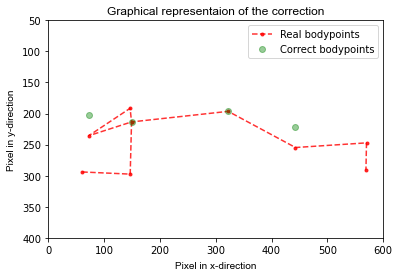

In [17]:
error_correction(4, video_1)